### Acknowledgement 
The code base is from the starter nb released by Johno W.
starter code link : 
https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge/data/ --> Starter_Notebook_CGIAR_Yield_Estimation.ipynb

# Setup

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# config setup for fast experiment
from src.config import Config

# some utilities
from src.utils import show_samples, process_im



# Small EDA

In [2]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv(os.path.join(Config.data_dir, 'Train.csv'))
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Loading D:\ZINDI\Computer_vision\CGIAR\data\image_arrays_train\4KWYCN9.npy as an array
Array shape: (360, 41, 41)


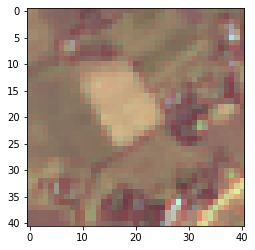

In [3]:
arr = show_samples(data_dir = Config.train_data_dir, df=train)

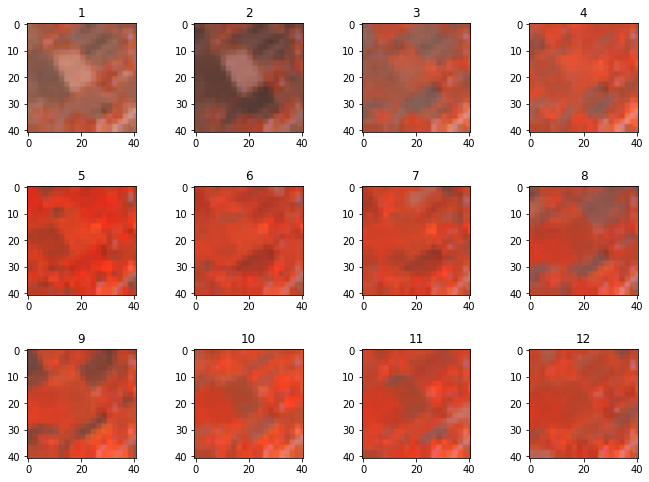

In [4]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

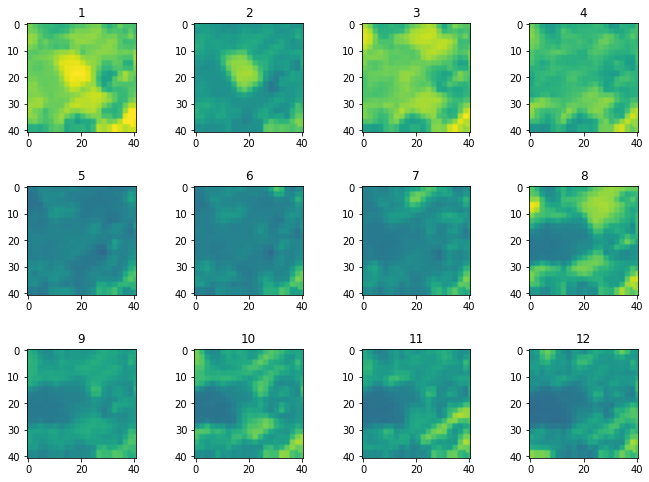

In [5]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

In [6]:
band_names = [l.strip() for l in open('../data/bandnames.txt', 'r').readlines()]

for line in band_names:
    print(line + '\n')

0_S2_B1

0_S2_B2

0_S2_B3

0_S2_B4

0_S2_B5

0_S2_B6

0_S2_B7

0_S2_B8

0_S2_B8A

0_S2_B9

0_S2_B10

0_S2_B11

0_S2_B12

0_S2_QA10

0_S2_QA20

0_S2_QA60

0_CLIM_aet

0_CLIM_def

0_CLIM_pdsi

0_CLIM_pet

0_CLIM_pr

0_CLIM_ro

0_CLIM_soil

0_CLIM_srad

0_CLIM_swe

0_CLIM_tmmn

0_CLIM_tmmx

0_CLIM_vap

0_CLIM_vpd

0_CLIM_vs

1_S2_B1

1_S2_B2

1_S2_B3

1_S2_B4

1_S2_B5

1_S2_B6

1_S2_B7

1_S2_B8

1_S2_B8A

1_S2_B9

1_S2_B10

1_S2_B11

1_S2_B12

1_S2_QA10

1_S2_QA20

1_S2_QA60

1_CLIM_aet

1_CLIM_def

1_CLIM_pdsi

1_CLIM_pet

1_CLIM_pr

1_CLIM_ro

1_CLIM_soil

1_CLIM_srad

1_CLIM_swe

1_CLIM_tmmn

1_CLIM_tmmx

1_CLIM_vap

1_CLIM_vpd

1_CLIM_vs

2_S2_B1

2_S2_B2

2_S2_B3

2_S2_B4

2_S2_B5

2_S2_B6

2_S2_B7

2_S2_B8

2_S2_B8A

2_S2_B9

2_S2_B10

2_S2_B11

2_S2_B12

2_S2_QA10

2_S2_QA20

2_S2_QA60

2_CLIM_aet

2_CLIM_def

2_CLIM_pdsi

2_CLIM_pet

2_CLIM_pr

2_CLIM_ro

2_CLIM_soil

2_CLIM_srad

2_CLIM_swe

2_CLIM_tmmn

2_CLIM_tmmx

2_CLIM_vap

2_CLIM_vpd

2_CLIM_vs

3_S2_B1

3_S2_B2

3_S2_B3

3

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [7]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID,Yield
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,83,93,744,699,393,790,125,215,MH2O0YH,3.686
1,880,821,924,1116,4,287,933,873,1011,1152,...,78,96,703,524,323,420,126,215,O9TURWL,5.657
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,75,93,2935,2961,3598,4145,135,289,35AFSDD,3.082
3,777,784,639,1064,3,299,832,875,823,1237,...,86,95,7289,7389,8025,8057,121,189,PM05EG9,2.707
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,122,1123,1054,1097,789,1349,194,1214,V7PZBCG,2.679


In [8]:
# save train_sampled dataframe
train_sampled.to_csv(os.path.join(Config.data_dir, 'train_sampled.csv'), index=False)

In [9]:
# save train_sampled dataframe
ss = pd.read_csv(os.path.join(Config.data_dir, 'SampleSubmission.csv'))

test_sampled = pd.DataFrame([process_im(fid, folder=os.path.join(Config.data_dir, 'image_arrays_test')) for fid in ss['Field_ID'].values])
test_sampled.to_csv(os.path.join(Config.data_dir, 'test_sampled.csv'), index=False)